# 03-Parameter estimation

_[Estimated execution time: 2 min]_

Spectral kernels are flexible but difficult to optimize, to solve this we equip the toolkit with different ways to initialize the parameters before training.

In this notebook we will showcase the diferent initialization for single output spectral mixture and multi output kernels.

For single output spectral mixture kernel there are three ways:
* __IPS__: uses a heuristic defined in Andrew Gordon Wilson's PhD thesis
    - Inverse of lengthscales drawn from truncated Gaussian |N(0, max_dist^2)|
    - Draw means from Unif(0, 0.5/minimum distance between two points)
    - Mixture weights should be roughly the std of the y values divided by the number of mixtures
    
    
* __BNSE__: uses Bayesian Nonparametric Spectral Estimation (Tobar 2018) to estimate the power spectral density (PSD) of the signal
    - Find the peaks in the PSD and order it by magnitude
    - Take the means as the position of the first Q peaks
    - Take the lengthscales as the width of the peaks multiplied by 2
    - Mixture weight as the peaks magnitudes normalized so the sum is equal to the channel variance


* __Lomb Scargle__: uses Lomb Scargle periodogram and obtain an estimate of the PSD, then follow the same heuristic as BNSE


* __SM__: fit and independent GP with spectral mixture kernel for each channel, then use those parameters as initial parameters

The noise for each channel is initializated as $1/30$ of the channels' variances.

In [70]:
import mogptk
import numpy as np

## Synthetic  Data

To showcase the initialization, we first create an artificial dataset of channels of sums of sinuoids:

$$ y(t) = \sum_{i=1}^{3} a_i \sin(t f_i) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_n^2) $$

With known frequencies $f_i$ and amplitudes $a_i$, when fiting the spectral mixture kernel we should should expect the _means_ to have similar values as the frequencies and the _mixture weigths_ to be in proportion of the amplitudes.

First we create a numpy array with the function, then we erase half of the data in order to do predictions.

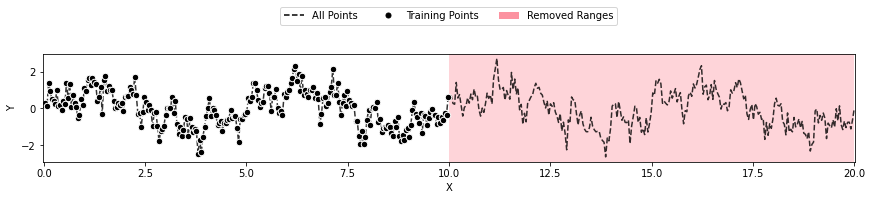

In [56]:
n_points = 500
frequencies = [0.2, 1.0, 2.0]
amplitudes = [1.0, 0.5, 0.5]

t = np.linspace(0.0, 20.0, n_points)
y = np.zeros(n_points)
for i in range(3):
    y += amplitudes[i] * np.sin(2.0*np.pi * frequencies[i] * t)
y += np.random.normal(scale=0.4, size=n_points)

# data class
data = mogptk.Data(t, y)
data.remove_range(start=10.0)
data.plot();

We show the spectrum and note that there are three peaks, one for each frequency.

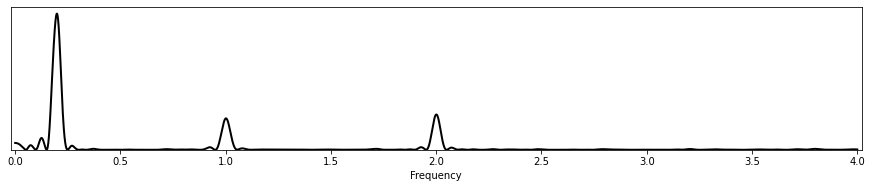

In [57]:
data.plot_spectrum(maxfreq=4.0);

## Without initialization

The kernel parameters are sampled randomly from $(0, 1]$, which is shown in the `plot_spectrum` function of the spectral mixture kernel.

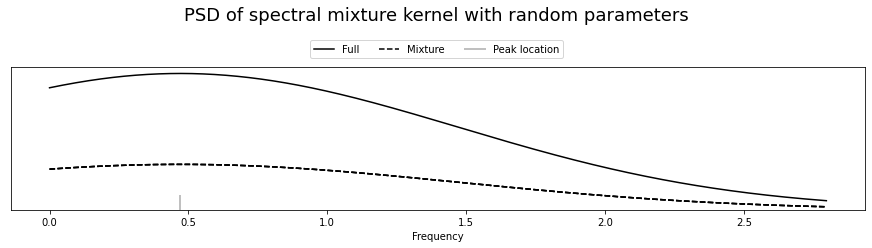

In [58]:
model = mogptk.SM(data, Q=3)
model.plot_spectrum(title='PSD of spectral mixture kernel with random parameters');

Now we can do predictions with the non-trained non-initialized model.

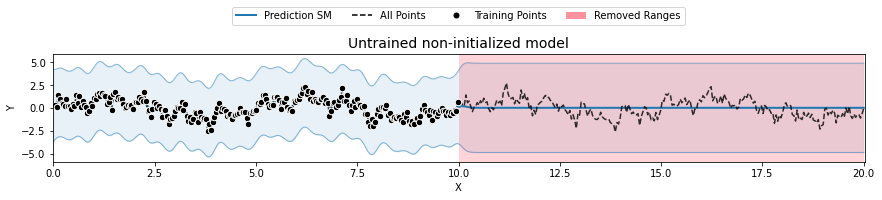

In [59]:
model.predict()
data.plot(title='Untrained non-initialized model');

## Initialization

Now we will initialize the parameters to improve training results. Other methods can be uncommented below to obtain the result of different initializations, see [`mogptk.SM.init_parameters`](https://games-uchile.github.io/mogptk/sm.html#mogptk.sm.SM.init_parameters) for more information.

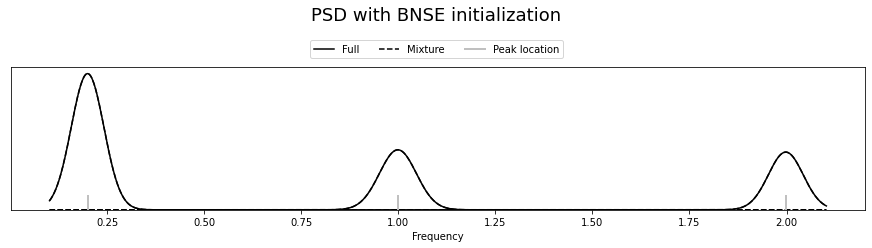

In [60]:
# initialize params
method = 'BNSE'
# method = 'LS'
# method = 'IPS'

model.init_parameters(method=method)
model.plot_spectrum(title='PSD with {} initialization'.format(method));

Name,Range,Value
Mixture[0].IMO.noise,"[1e-08,∞)",[1.]
Mixture[0].IMO[0].SM.weight,"[1e-08,∞)",[0.95305305]
Mixture[0].IMO[0].SM.mean,"[1e-08,∞)",[0.1997998]
Mixture[0].IMO[0].SM.variance,"[1e-08,∞)",[0.04210029]
Mixture[1].IMO.noise,"[1e-08,∞)",[1.]
Mixture[1].IMO[0].SM.weight,"[1e-08,∞)",[0.47458888]
Mixture[1].IMO[0].SM.mean,"[1e-08,∞)",[0.998999]
Mixture[1].IMO[0].SM.variance,"[1e-08,∞)",[0.04757718]
Mixture[2].IMO.noise,"[1e-08,∞)",[1.]
Mixture[2].IMO[0].SM.weight,"[1e-08,∞)",[0.4309439]


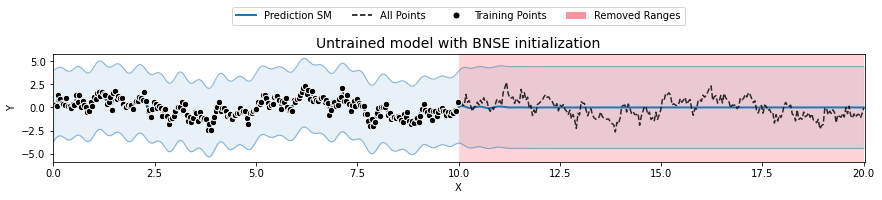

In [61]:
model.print_parameters()
model.predict()
data.plot(title='Untrained model with {} initialization'.format(method));

## Training


Starting optimization using Adam
‣ Model: SM
‣ Channels: 1
‣ Mixtures: 3
‣ Training points: 250
‣ Parameters: 12
‣ Initial NLL: 1.635

Optimization finished in 0.03 minutes
‣ Function evaluations: 100
‣ Final NLL: 0.579


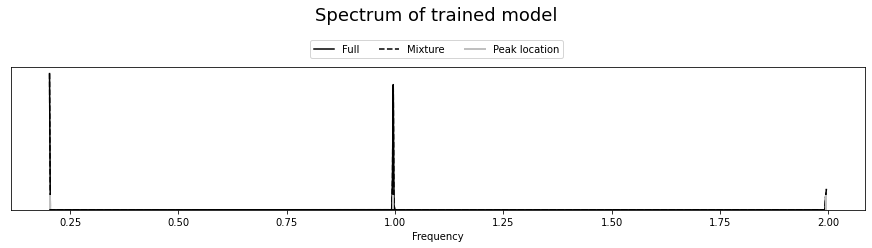

In [62]:
model.train(iters=100, lr=0.5, verbose=True)
model.plot_spectrum(title='Spectrum of trained model');

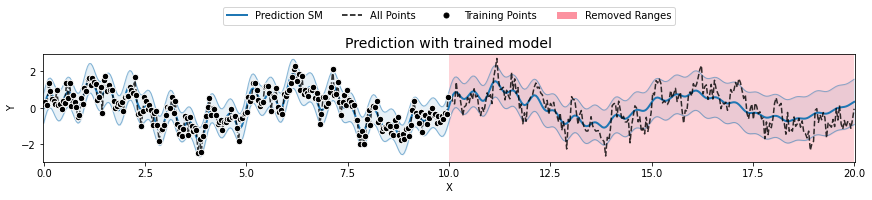

In [63]:
model.predict()
data.plot(title='Prediction with trained model');

Now we can compare the trained model with the original frequencies. Note the `weight` and `mean` parameters of the spectral mixture kernel for each mixture.

In [64]:
print('Target frequencies:', frequencies)
print('Target amplitudes:', amplitudes)

Target frequencies: [0.2, 1.0, 2.0]
Target amplitudes: [1.0, 0.5, 0.5]


In [65]:
model.print_parameters()

Name,Range,Value
Mixture[0].IMO.noise,"[1e-08,∞)",[0.05108852]
Mixture[0].IMO[0].SM.weight,"[1e-08,∞)",[0.25083174]
Mixture[0].IMO[0].SM.mean,"[1e-08,∞)",[0.20308847]
Mixture[0].IMO[0].SM.variance,"[1e-08,∞)",[0.00021593]
Mixture[1].IMO.noise,"[1e-08,∞)",[0.05108852]
Mixture[1].IMO[0].SM.weight,"[1e-08,∞)",[0.06515985]
Mixture[1].IMO[0].SM.mean,"[1e-08,∞)",[0.99544952]
Mixture[1].IMO[0].SM.variance,"[1e-08,∞)",[0.00082961]
Mixture[2].IMO.noise,"[1e-08,∞)",[0.05108852]
Mixture[2].IMO[0].SM.weight,"[1e-08,∞)",[0.06398291]


# Initialization for multi output kernels

First we create a similar dataset as the one used in the [00 - Quick Start](https://github.com/GAMES-UChile/mogptk/blob/master/examples/00_Quick_Start.ipynb) tutorial.

In [66]:
n_points = 100
t = np.linspace(0, 6, n_points)

y1 = np.sin(6.0*t) + 0.2*np.random.normal(size=len(t))
y2 = np.sin(6.0*t + 2.0) + 0.2*np.random.normal(size=len(t))
y3 = np.sin(6.0*t) - np.sin(4 * t) + 0.2*np.random.normal(size=len(t))
y4 = 4.0*np.sin(6.0*(t-2.0)) + 0.3*np.random.normal(size=len(t))

dataset = mogptk.DataSet(t, [y1, y2, y3, y4], names=['A','B','C','D'])
for data in dataset:
    data.remove_randomly(pct=0.3)
dataset[0].remove_range(start=2.0)

## Create model

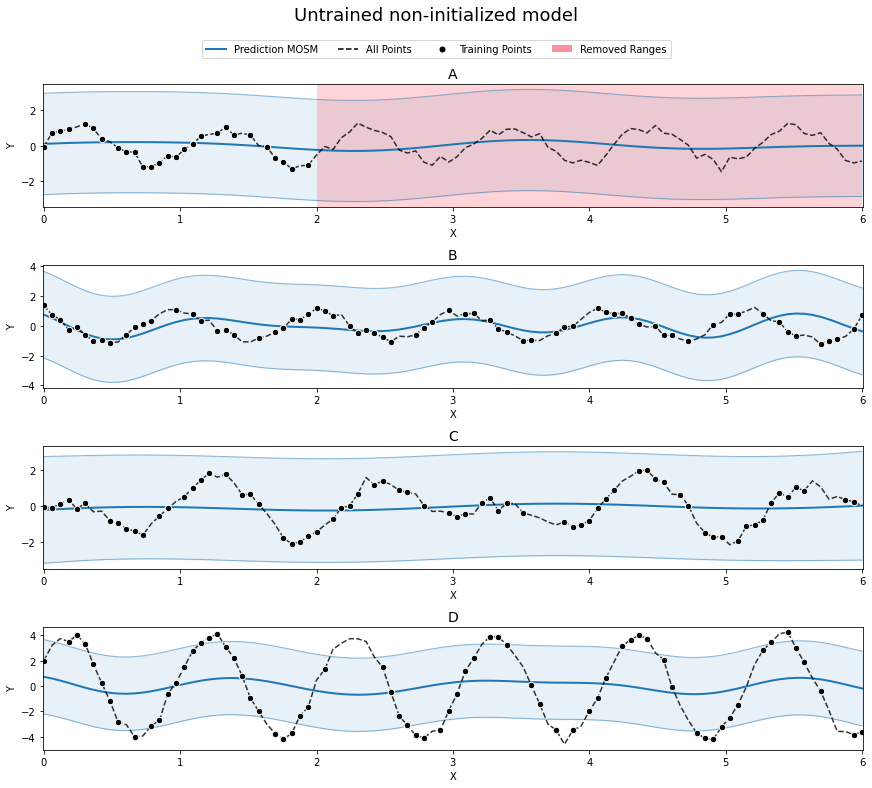

In [67]:
model = mogptk.MOSM(dataset, Q=2)
model.predict()
dataset.plot(title='Untrained non-initialized model');

## Initialization

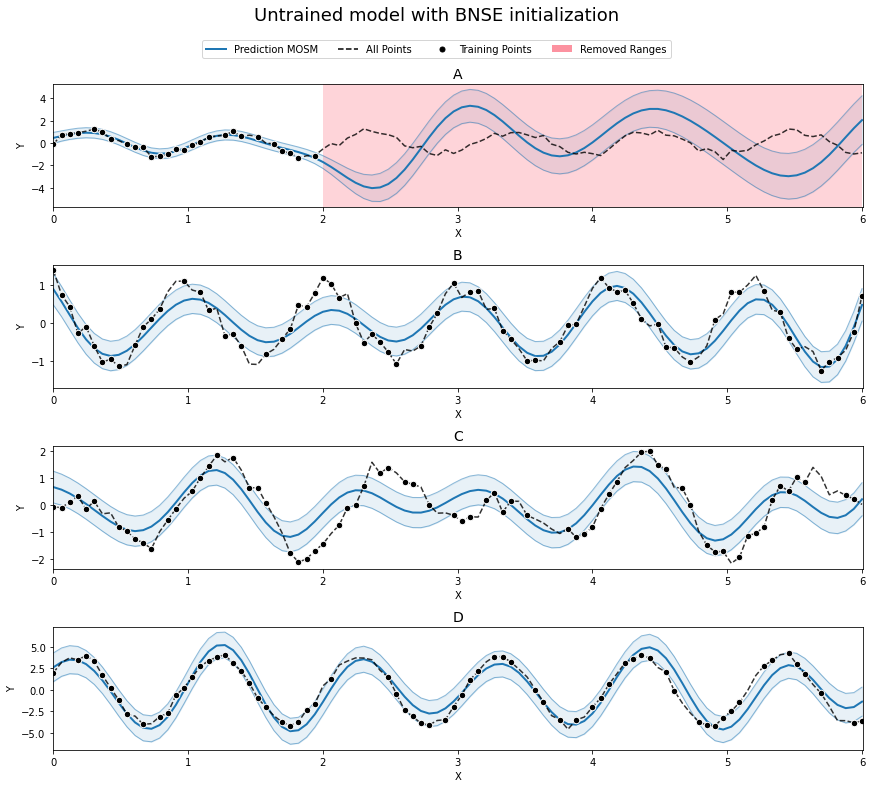

In [68]:
method = 'BNSE'
# method = 'SM'
# method = 'LS'

model.init_parameters(method)

model.predict()
dataset.plot(title='Untrained model with {} initialization'.format(method));

## Training


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 237
‣ Parameters: 48
‣ Initial NLL: 2.004

Optimization finished in 0.31 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.020


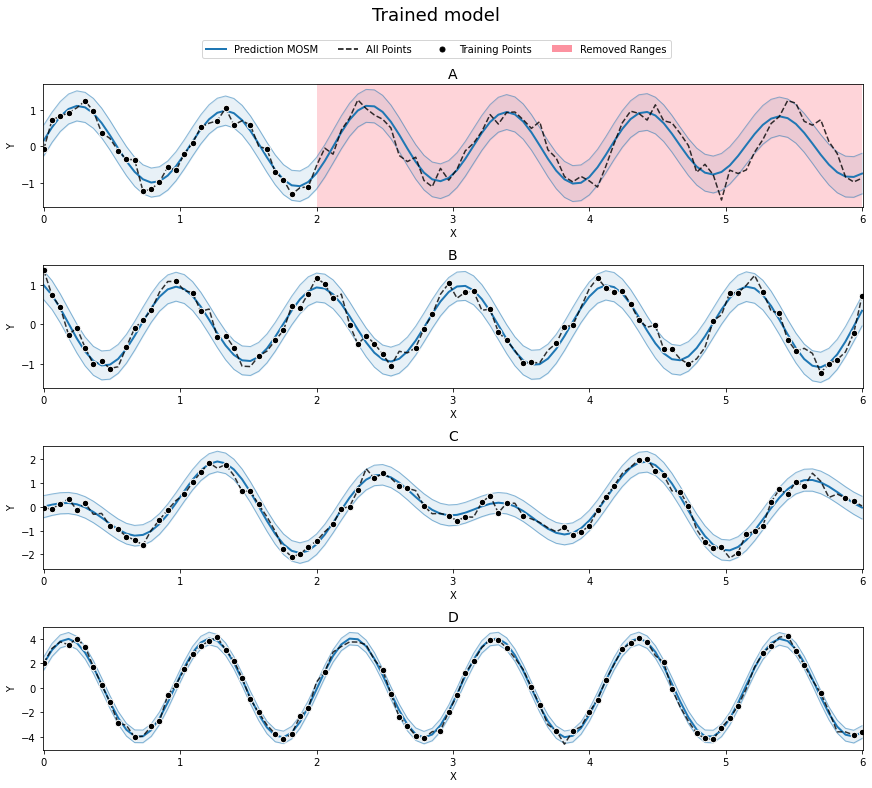

In [69]:
model.train(iters=500, lr=0.5, verbose=True)

model.predict()
dataset.plot(title='Trained model');